In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

In [2]:
# Read in the data
data_path = '../../preprocessing/data'

# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet')
# Columns in A but not in test_A

# Columns to drop






A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])


print(f'obs A size {test_A.shape} estimated A size {A.shape}')

print(A.columns.difference(test_A.columns))



obs A size (720, 55) estimated A size (34085, 56)
Index(['pv_measurement'], dtype='object')


In [3]:
import re

def clean_feature_names(data):
    # Replace any non-alphanumeric character (excluding underscore) with an underscore
    return data.rename(columns=lambda name: re.sub(r'[^\w]', '_', name))


In [4]:
X_A = A.drop(columns=['pv_measurement'])
y_A = A['pv_measurement']

# Function to clean the feature names


# Then you can proceed with your code to drop, split, and use the features for LightGBM as you were doing.


# Split the dataset into training and testing sets
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.5, shuffle=True, random_state=42)
# Replace special JSON characters in column names
X_train_A.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in X_train_A.columns]
X_test_A.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in X_test_A.columns]
X_A.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in X_train_A.columns]
test_A.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in test_A.columns]


# Initialize LGBMRegressor with parameters. Adjust the parameters as per your requirements.
lgb_params = {
    'num_leaves': 31, 
    'learning_rate': 0.02, 
    'n_estimators': 500, 
    'max_depth': 14, 
    'reg_lambda': 3, 
    'objective': 'regression', 
    'metric': 'mae', 
    'random_state': 42
}

# Create the LGBMRegressor model with the given parameters
model_A = LGBMRegressor(**lgb_params)

# Fit the model on the training data
model_A.fit(X_A, y_A, eval_set=[(X_test_A, y_test_A)], eval_metric='mae', verbose=100, early_stopping_rounds=50)

# Predict on the test data
pred_test_A = model_A.predict(X_test_A)


/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: date_forecast

MAE: 141.22039464129668


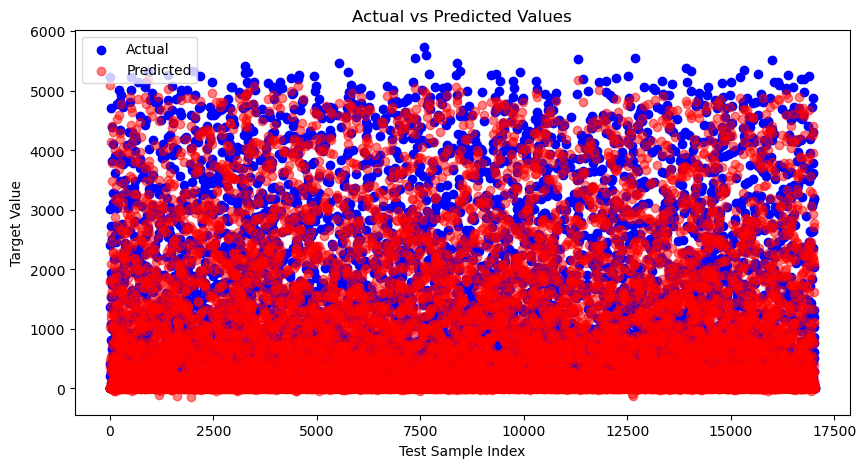

In [ ]:
#test model performance for A

y_pred_A_test = model_A.predict(X_test_A)

# Calculate the mse
mse = mean_absolute_error(y_test_A, y_pred_A_test)
print(f'MAE: {mse}')



# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_A)), y_test_A, color='blue', label='Actual')
plt.scatter(range(len(y_pred_A_test)), y_pred_A_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

                         Feature Name  Importance
46                   day_length_hours         110
58                 visibilitym_lag_-2          89
33           sun_elevationd_fft_phase          85
18              wind_vector_magnitude          85
54  relative_humidity_1000hPap_lag_-3          80
..                                ...         ...
53              dew_or_rimeidx_lag_11           9
24                    pressure_50mhPa           8
28                               year           1
45                           observed           0
29                               hour           0

[70 rows x 2 columns]


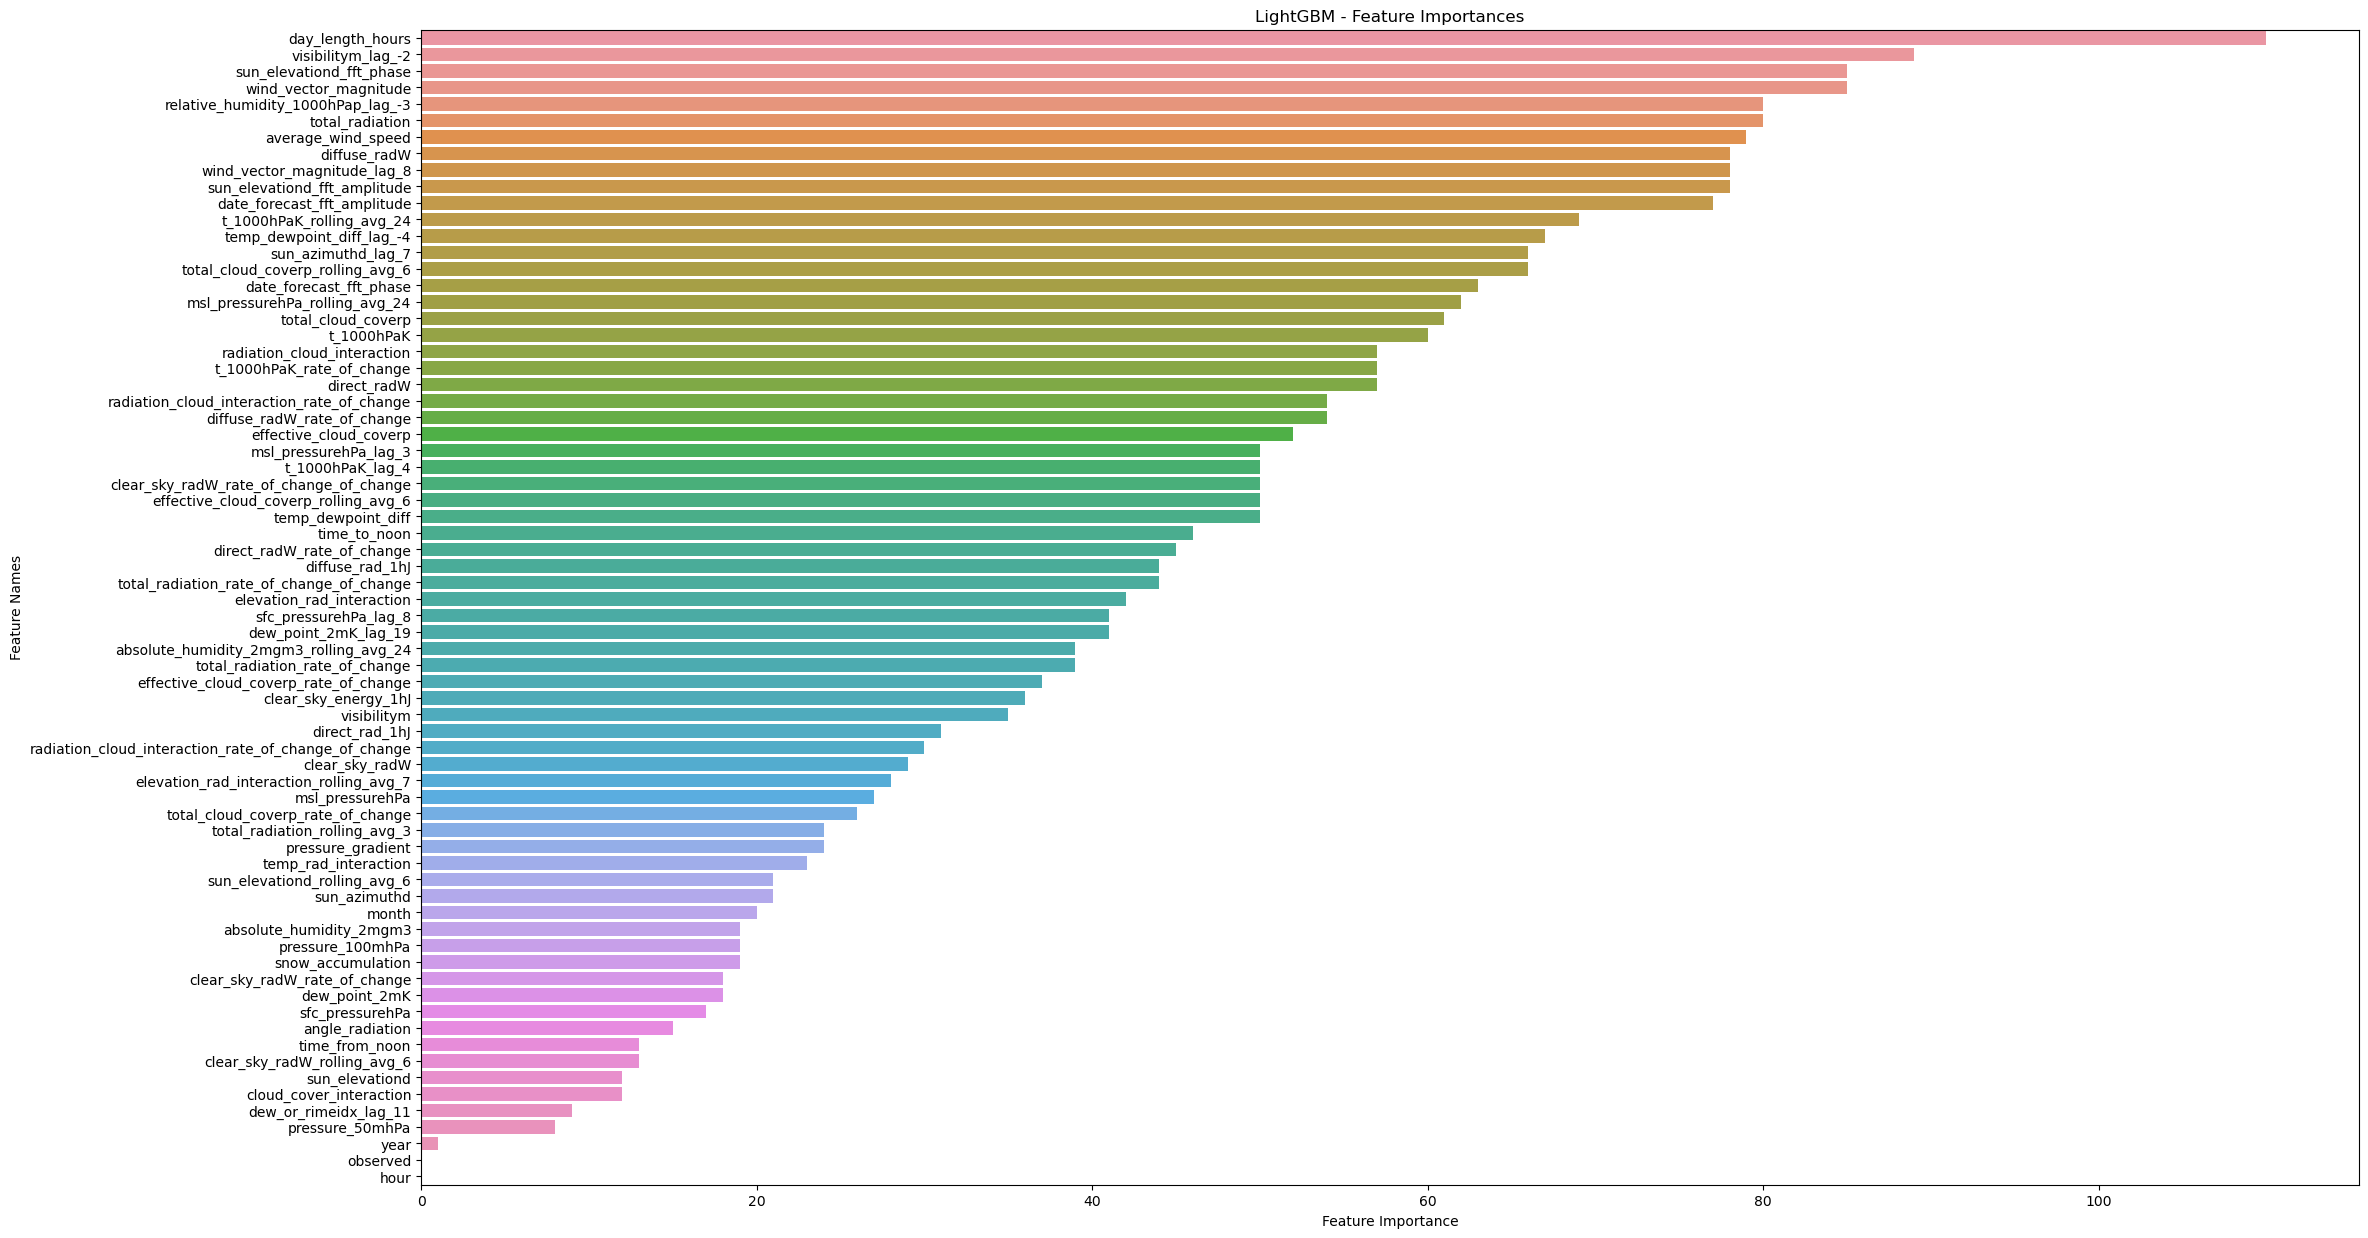

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = model_A.feature_importances_

# Create a dataframe to view feature importances in a more readable format
feature_names = X_train_A.columns
feature_importance_df = pd.DataFrame({'Feature Name': feature_names, 'Importance': importances})

# Print feature importances
print(feature_importance_df.sort_values(by='Importance', ascending=False))

# Get important features with non-zero importance
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.0]['Feature Name'].values

# Function to plot feature importance
def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(25,15))  # Adjusted for better fit on typical screens
    # Plot seaborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + ' - Feature Importances')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

# Call the function to plot feature importance for LightGBM
plot_feature_importance(importances, feature_names, 'LightGBM')
plt.show()


In [ ]:
X_B = B.drop(columns=['pv_measurement'])
y_B = B['pv_measurement']

# Split the dataset into training and testing sets
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.5, shuffle=False, random_state=42)

# Replace special JSON characters in column names for 'B' dataset
X_train_B.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in X_train_B.columns]
X_test_B.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in X_test_B.columns]
X_B.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in X_train_B.columns]
test_B.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in test_B.columns]

# Initialize and fit the LGBMRegressor model for 'B' dataset with parameters
lgb_params_B = {
    'num_leaves': 31, 
    'learning_rate': 0.02, 
    'n_estimators': 700, 
    'max_depth': 14, 
    'reg_lambda': 3, 
    'objective': 'regression', 
    'metric': 'mae', 
    'random_state': 42,
}

model_B = LGBMRegressor(**lgb_params_B)
model_B.fit(X_B, y_B, eval_set=[(X_test_B, y_test_B)], eval_metric='mae', verbose=100, early_stopping_rounds=50)



/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l1: 33.22
[200]	valid_0's l1: 20.2919
[300]	valid_0's l1: 17.2202
[400]	valid_0's l1: 15.8986
[500]	valid_0's l1: 14.8164
[600]	valid_0's l1: 13.9285
[700]	valid_0's l1: 13.2428


LGBMRegressor(learning_rate=0.02, max_depth=14, metric='mae', n_estimators=700,
              objective='regression', random_state=42, reg_lambda=3)

MAE: 13.242770094327991


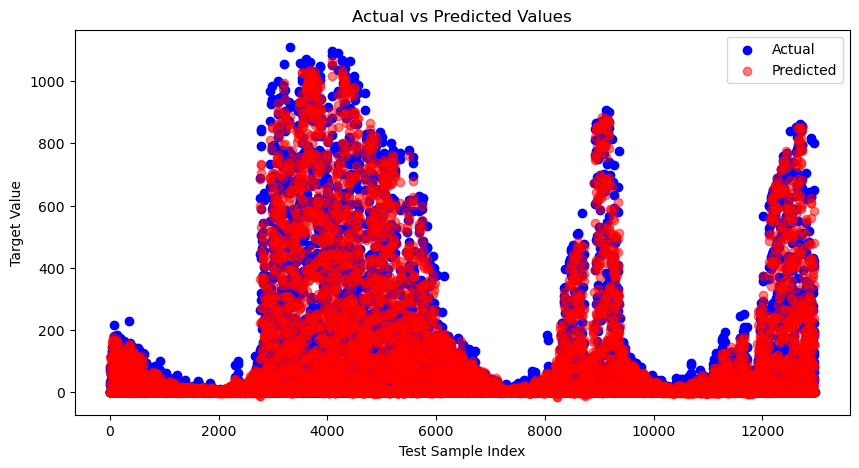

In [ ]:
y_pred_B_test = model_B.predict(X_test_B)

# Calculate the mse
mse = mean_absolute_error(y_test_B, y_pred_B_test)
print(f'MAE: {mse}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_B)), y_test_B, color='blue', label='Actual')
plt.scatter(range(len(y_pred_B_test)), y_pred_B_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

In [ ]:
X_C = C.drop(columns=['pv_measurement'])
y_C = C['pv_measurement']

# Split the dataset into training and testing sets
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, shuffle=True, random_state=42)

# Replace special JSON characters in column names for 'C' dataset
X_train_C.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in X_train_C.columns]
X_test_C.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in X_test_C.columns]
X_C.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in X_train_C.columns]
test_C.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in test_C.columns]

# Initialize and fit the LGBMRegressor model for 'C' dataset with parameters
lgb_params_C = {
    'num_leaves': 31, 
    'learning_rate': 0.02, 
    'n_estimators': 700, 
    'max_depth': 14, 
    'reg_lambda': 3, 
    'objective': 'regression', 
    'metric': 'mae', 
    'random_state': 42,
}

model_C = LGBMRegressor(**lgb_params_C)
model_C.fit(X_C, y_C, eval_set=[(X_test_C, y_test_C)], eval_metric='mae', verbose=100, early_stopping_rounds=50)


/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l1: 32.827
[200]	valid_0's l1: 21.2385
[300]	valid_0's l1: 18.2328
[400]	valid_0's l1: 16.763
[500]	valid_0's l1: 15.659
[600]	valid_0's l1: 14.6695
[700]	valid_0's l1: 13.8407


LGBMRegressor(learning_rate=0.02, max_depth=14, metric='mae', n_estimators=700,
              objective='regression', random_state=42, reg_lambda=3)

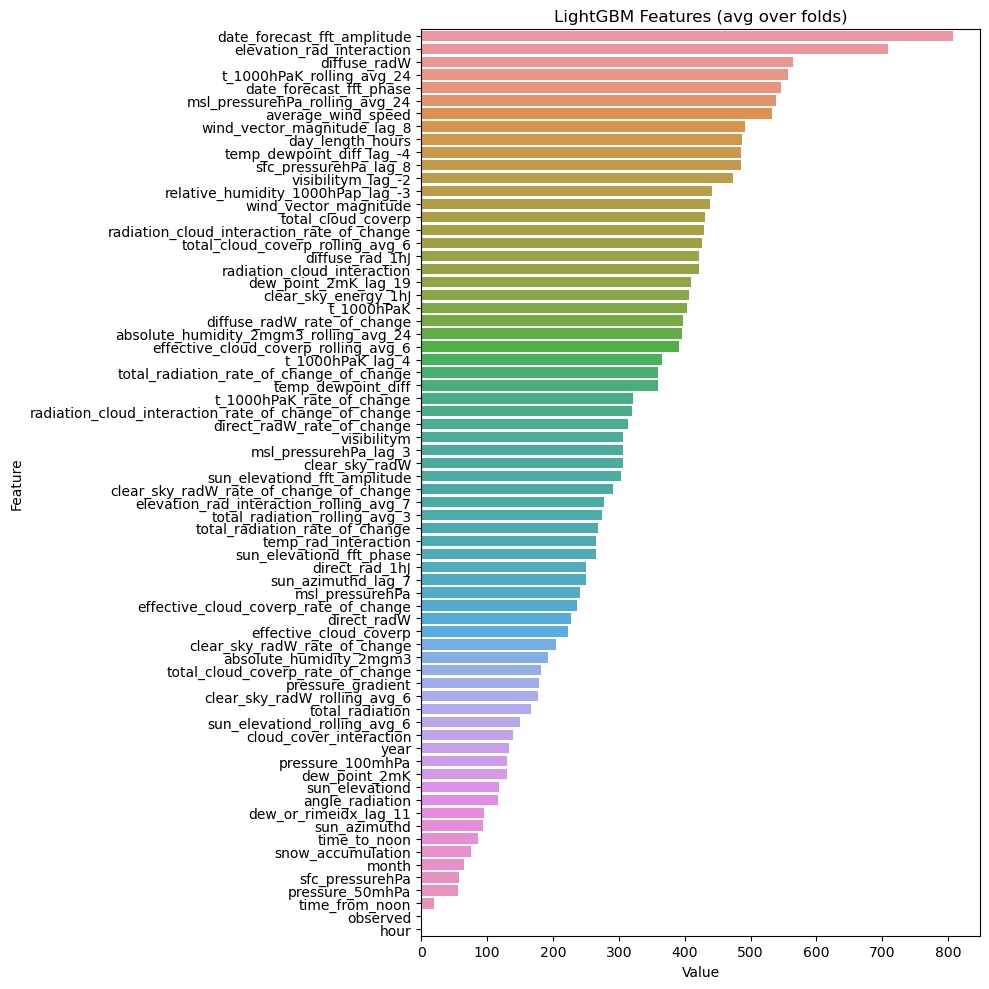

MAE: 13.84073666859055


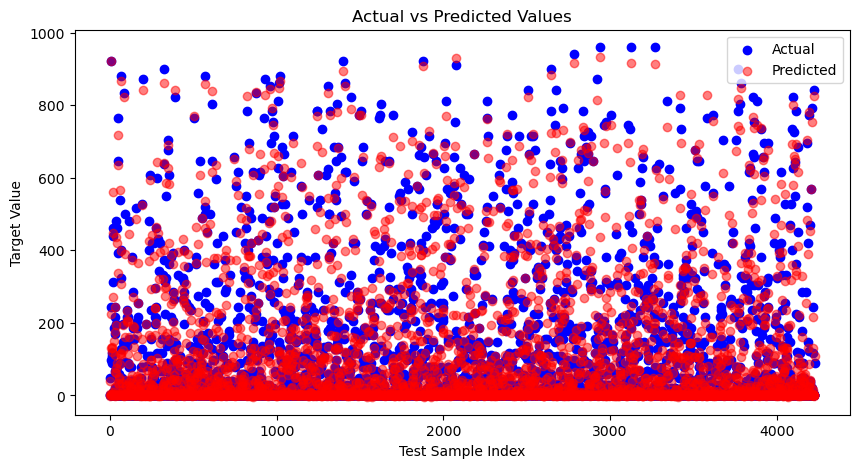

In [ ]:
# plot model performance for C

y_pred_C_test = model_C.predict(X_test_C)

# print out feature importance
feature_importance = pd.DataFrame(sorted(zip(model_C.feature_importances_, X_C.columns)), columns=['Value','Feature'])
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()


# Calculate the mse
mse = mean_absolute_error(y_test_C, y_pred_C_test)
print(f'MAE: {mse}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_C)), y_test_C, color='blue', label='Actual')
plt.scatter(range(len(y_pred_C_test)), y_pred_C_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [ ]:
def create_submission(pred_A, pred_B, pred_C, output_file="submission.csv"):
    """
    Create a Kaggle submission file.

    Parameters:
    - pred_A, pred_B, pred_C: Arrays containing predictions.
    - output_file: Name of the output CSV file.

    Returns:
    - None. Writes the submission to a CSV file.
    """
    
    # Concatenate predictions
    predictions = np.concatenate([pred_A, pred_B, pred_C])

    # Create an id array
    ids = np.arange(0, len(predictions))

    # Create a DataFrame
    df = pd.DataFrame({
        'id': ids,
        'prediction': predictions
    })

    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")


test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet')

test_A = test_A.drop(columns=columns)
test_B = test_B.drop(columns=columns)
test_C = test_C.drop(columns=columns)

# drop PV_measurement from test data


pred_A = model_A.predict(test_A)
pred_B = model_B.predict(test_B)
pred_C = model_C.predict(test_C)

create_submission(pred_A, pred_B, pred_C, output_file="../../catty_boosty_submission.csv")

Submission saved to ../../catty_boosty_submission.csv
